# 最尤推定の可視化

In [50]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns; sns.set()
from sklearn.preprocessing import PolynomialFeatures

# pcolormesh と pcolor の deprecated 問題を封じておく
plt.rcParams['axes.grid'] = False

plt.rcParams['font.size'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['image.cmap'] = 'plasma'
# sns.set_context('talk')

使い方メモ
* PolynomialFeatures(M)
* poly.fit_transform(x.reshape(N, 1))

\begin{align}
&input :: X = [[x_1], [x_2], \cdots, [x_N]]\\
&output :: X = [[1, x1, x_1^2, \cdots, x_1^M], [1, x2, x2^2, \cdots, x_2^M ], \cdots, [1, x_N, x_N^2, \cdots, x_N^M ]]^T
\end{align}

In [51]:
def model_func(x, w):
    Mdim = w.shape[0]
    Ndim = x.shape[0]
    poly = PolynomialFeatures(Mdim-1)   # 計画行列
    phi = poly.fit_transform(x.reshape(Ndim, 1))
    return(phi @ w)

## データ生成

In [52]:
N = 15

# モデルの真値
a_true = 0.9
b_true = 0.2
sigma_true = 0.1
beta_true = 1/sigma_true**2

w_true = np.array([b_true, a_true])

# 乱数シード固定
np.random.seed(0)

# [0, 1] ランダム
x = np.random.rand(N)

# ytrue を求めておく
y_true = model_func(x, w_true)

# 観測データ
epsilon = sigma_true * np.random.randn(N)
y = y_true + epsilon

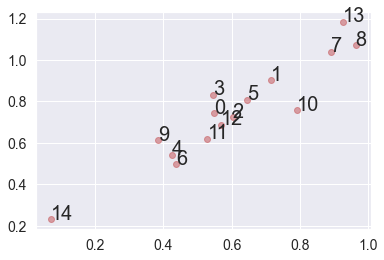

In [53]:
# 描写
plt.figure()
plt.plot(xx, yy)

for n in range(N):
    plt.plot(x[n], y[n], 'ro', alpha=0.5)
    plt.annotate(n, xy=(x[n], y[n]))

plt.grid()

## 対数尤度関数の計算と可視化

In [54]:
# 対数尤度関数
def log_likelihood(w, beta, x, y):
    Ndim = x.shape[0]
    const = Ndim/2 * np.log(beta/(2*np.pi))
    loss = np.sum((y - model_func(x, w))**2) 
    return -beta / 2 * loss + const

mesh作成メモ
```pyrhon
# 0~1 128分割
x = np.linspace(0, 1, 128)
y = np.linspace(0, 1, 128)
x, y = np.meshgrid(y, x)
xy = np.array([x.ravel(), y.ravel()])
z = func([func(xy[:, m]) for m in range(M)])
z = np.array(z).reshape(128, 128)

# いつも通りのグラフ設定をして等高線表示を記述
plt.contourf(x, y, z,  alpha=0.6)
plt.colorbar()
```


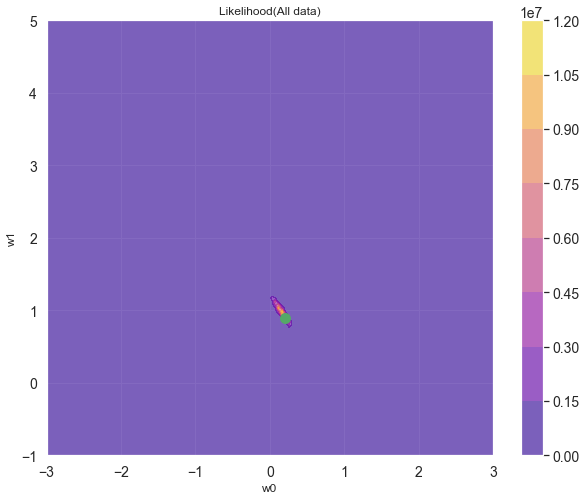

In [55]:
# 尤度計算とグラフ空間の作成

# settings
delta = 128   # メッシュの細かさ
w0lim = (-3, 3) 
w1lim = (-1, 5)  
# create meshgrid
w0shp = np.linspace(w0lim[0], w0lim[1], delta)
w1shp = np.linspace(w1lim[0], w1lim[1], delta)
w1_p, w0_p = np.meshgrid(w1shp, w0shp)
w = np.array([w0_p.ravel(), w1_p.ravel()])

# 尤度関数計算
Wary = np.array(w)
M = Wary.shape[1]
llist = [log_likelihood(Wary[:, m], beta_true, x, y) for m in range(M)]

# 行列の形にして等高線プロット
z = np.array(llist).reshape(delta, delta)

plt.figure(figsize=(10, 8))
plt.ylim(w1lim[0], w1lim[1])
plt.xlim(w0lim[0], w0lim[1])

plt.contourf(w0_p, w1_p, np.exp(z),  alpha=0.6)  #cm.gist_heatにするとかっこいい
plt.colorbar()

plt.grid()
plt.xlabel('w0')
plt.ylabel('w1')
plt.title('Likelihood(All data)')
plt.scatter(w_true[0], w_true[1], c='g', s=100)

## w0,w1の推定過程
各1点のx, yによって求まる、w0,w1が取り得る確率の高いところは直線になる。
この確率をすべての点について掛け合わせると、徐々に尤もらしいところの確率が高くなる。

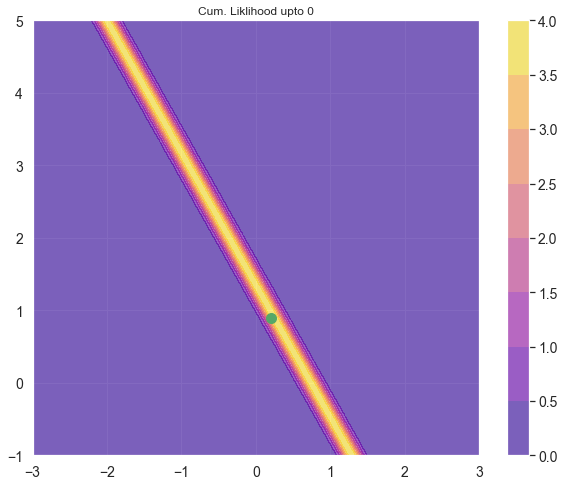

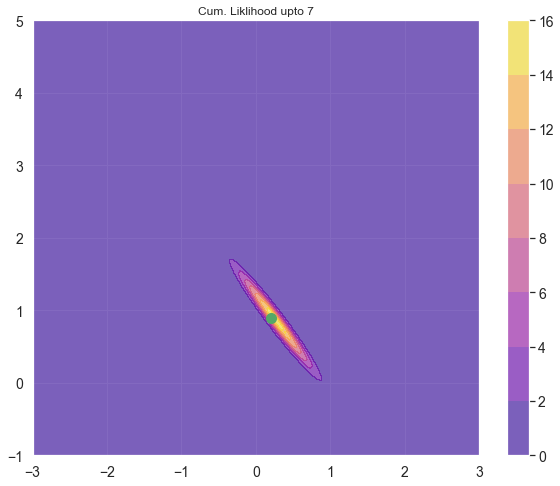

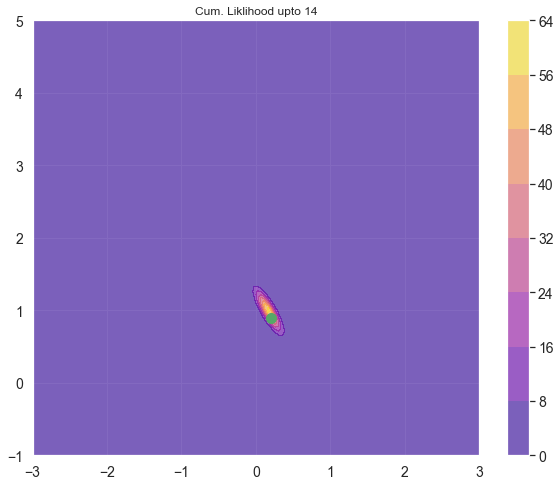

In [56]:
# 累積の値を zcum に足しこむ
zcum = np.zeros((delta, delta))
Wary = np.array(w)
for n in range(3):
    n *= 7
    M = w.shape[1]
    xx = x[n:n+1]
    yy = y[n:n+1]
    llist = [log_likelihood(Wary[:, m], beta_true, xx, yy) for m in range(M)]

    z = np.array(llist).reshape(delta, delta)
    zcum = zcum + z
    
    plt.figure(figsize=(10, 8))
    plt.ylim(w1lim[0], w1lim[1])
    plt.xlim(w0lim[0], w0lim[1])

    plt.contourf(w0_p, w1_p, np.exp(zcum), alpha=0.6)  #cm.gist_heatにするとかっこいい
    plt.colorbar()
    plt.grid()

    plt.scatter(w_true[0], w_true[1], c='g', s=100)
    plt.title('Cum. Liklihood upto {}'.format(n))